# CP 2024-25: Q2 Lecture 4 - Optimization (Part 1)

### General Guidelines

> ⚠️⚠️⚠️ READ CAREFULLY ⚠️⚠️⚠️

- Do not add, delete or create cells, write the answer only in the space marked with the three dots (`...`). Where function skeletons are provided, it is assumed that that function can be called again with different inputs somewhere else. So be careful to write code outside of functions.
  - Function should be ['pure'](https://en.wikipedia.org/wiki/Pure_function), thus no side effects, unless otherwise specified.
- Run the the first cell to import all libraries when opening the notebook before running your own code.
- Read carefully what is required to be printed/returned/plotted in the answer. Please do not output what is not asked for. 
  - If you used the print function for debugging, comment it out ( Ctlr + / ) before submitting
- All plots should have title, xlabel, ylabel, and legend (if there are more than one curve on the plot)
- Use the `help()` function, consult python documentation when using new functions, or do a web search and consult [stackoverflow](https://stackoverflow.com/questions/tagged/python)
- Please read the error messages if you get any, and try to understand what they mean. Debugging code is an essential skill to develop.
- You can use `%debug` to start an IPython console in a cell (or a scratchpad cell!) after an exception has occurred to try to debug.
- You can use `%pdb` to toggle the Python DeBugger (pdb) auto start after an unhandled exception.
- In the assignments you will find some tests put in place, to help you verify your solution. If these fail you are certain you did something wrong, thus look at the hints they provide. But passing these tests does __not__ mean your solution is actually correct.

Make sure you use `python3.11` and the package versions as stated in the provided `requirements.txt`. This file should also be on the course page.

In [1]:
# Importing relevant libraries in the assignment

# This will create static plots (no zooming etc.)
# otherwise try just plain `%matplotlib`, or install a backend such as ipympl or PyQt5 and
# do or `%matplotlib ipympl` `%matplotlib qt`
%matplotlib inline

REPEAT_IMPORTS = True

if REPEAT_IMPORTS or ("IMPORTED_ALL" not in globals()):  # To save you a bit of time

    def print_import_info(package):
        print(
            "Successfully imported %-15s \tVersion: %10s"
            % (package.__name__, package.__version__)
        )

    ### Standard library imports

    import sys

    print("Python version {}".format(sys.version))
    if sys.version_info < (3, 8):
        print(
            "\u001b[31m"  # red
            "\u001b[1m"  # bold
            "WARNING: Use Python 3.8 or newer not to encounter any errors or problems later on. You can chance the the version. This sometime can be done by switching the kernel under the 'Kernel' tab."
            "\u001b[0m"  # reset
        )
    del sys  # Do not need it anymore

    # import functools
    import typing
    from typing import Dict, List, Tuple, Union

    ### Import third party libraries
    # Initialize self assessment helper
    import otter

    grader = otter.Notebook("Assignment_Q2_L4.ipynb")

    import os

    import numpy as np
    import numpy.typing as npt

    print_import_info(np)

    import scipy
    import scipy.optimize

    print_import_info(scipy)

    IMPORTED_ALL = True
    print("Finished importing packages")
else:
    print("Already imported all packages")

Python version 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Successfully imported numpy           	Version:      2.3.2
Successfully imported scipy           	Version:     1.16.1
Finished importing packages


## Maximizing the production of dimethyl ether using unconstrained optimization techniques in SciPy.
Consider a chemical manufacturing facility to manufacture dimethyl ether (DME) and Diethyl ether (DEE) using methanol and ethanol. <br>
The plant is modelled in ASPEN plus and as a simulation engineer you conducted multiple simulations in ASPEN to generate operational data of the plant under various scenarios. <br>
The process flowsheet of the plant is shown below:<br>
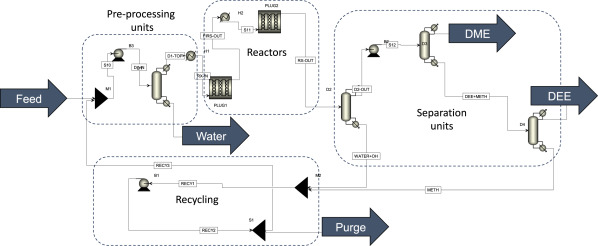

The image is taken from [1]. The flowsheet and the case study are taken from [2] <br>

After multiple simulations, you have identified the important input variables affecting the production of DME are:<br>
- Mass flowrate of methanol in the FEED stream ($x_1$) <br>
- Mass flowrate of ethanol in the FEED stream ($x_2$) <br>
- Mass flowrate of water in the FEED stream ($x_3$) <br>
- Mass flowrate of the PURGE stream ($x_4$) <br>

Due to market considerations, you realized that DME is more valuable and you would like to maximize the production of DME in the DME stream in the flowsheet. <br>
You realize after conducting multiple simulations that getting the recycle to converge in ASPEN is time-consuming. <br>
Hence you decided to use the data you have from multiple simulations you conducted to regress an algebraic expression (commonly known as a surrogate model) relating the input variables to the mass flowrate of DME in the DME stream ($y$). <br>

The optimal surrogate model found on conducting regression is: <br>
\begin{align*}
y & = x_1/0.957 - 0.303(x_4 + (-0.303((x_3 + 0.34(x_3 - x_4)) + 0.278(x_3 - x_4)))) \\
\tag{Eq. 1}
\end{align*}

Before the production rate is optimized, these are some considerations to account for in this exercise:<br>
1. The inputs and outputs have been scaled to improve the regression performance. 
\begin{equation*}
\mathbf{x}^{\rm scaled} = \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}
\end{equation*}
The mean ($\boldsymbol{\mu}$) vector for the inputs ($x_1, x_2, x_3, x_4$) is [12.70348859, 11.62070922, 6.5913778, 6.8440909] <br>
The standard deviation vector ($\boldsymbol{\sigma}$) for the inputs ($x_1, x_2, x_3, x_4$) is [4.75141695, 4.77257705, 3.57559294, 3.6442073] <br>
The mean ($\boldsymbol{\mu}$) vector for the output ($y$) is [6.8769097] <br>
The standard deviation vector ($\boldsymbol{\sigma}$) for the outputs ($y$) is [2.8264008] <br>

2. The regression model is trained for a certain range of inputs where simulations have been conducted. 
It is not advisable to find the optimum production rate outside these ranges since the regression model is not trained in them.
Hence, you need to bound the inputs with the given ranges:
 - $x_1 \in [-2.24191432, 1.51706602]$
 - $x_2 \in [-2.01455836, 1.73137311]$
 - $x_3 \in [-1.28480703, 3.196982]$
 - $x_4 \in [-1.87022356, 4.08453871]$ 

Please note these ranges are scaled based on the scaler used to train the regression model.


Given this information, use the optimize function in SciPy to determine the maximum production rate of DME, the optimal FEED rates for methanol, ethanol, and water and the optimal PURGE rate. <br>

### Numerical solution strategies
To determine the minimum cost we will use the  **Optimization and root finding** functionality in SciPy. <br>
First we need to define a function which can estimate the production rate of DME. <br>
We then pass this function as an argument to scipy.optimize.minimize to find the maximum production rate and optimal FEED and PURGE rates. <br>
You can try different unconstrained optimization methods covered in the lecture which are available in SciPy and comment on the solutions you obtain. <br>

### References
1. Chen, H., Flores, G. E. C., & Li, C. (2024). Physics-informed neural networks with hard linear equality constraints. Computers & Chemical Engineering, 189, 108764.
2. Ma, K., Sahinidis, N. V., Bindlish, R., Bury, S. J., Haghpanah, R., & Rajagopalan, S. (2022). Data-driven strategies for extractive distillation unit optimization. Computers & Chemical Engineering, 167, 107970.

### Question 1: Maximize the production rate of DME using SciPy
You should define a set of variables comprising the inputs $x_1, x_2, x_3, x_4$ as described in the problem statement..


#### Instructions

1. **Creating a Python function to determine production rate of DME**:
   - Create a new Python function named **`determine_prod_rate`** where the function arguments are $x_1$, $x_2$, $x_3$, $x_4$.
   - Create an appropriate docstring for the function.
   - Return the production rate of DME.
   - Keep in mind that Scipy only allows minimization of functions. You may have to adjust the relation for production rate accordingly. 
   - For the point above refer to the lecture slides (c.f. Slide 8) discussing equivalence of objective functions.

2. **Creating a Python function to unscale the inputs to original scaling**:
   - Create a new Python function named **`unscale_inputs`** where the function arguments are **`vars`**, **`mean`**, **`sd`**.
   - Unpack $x_1$, $x_2$, $x_3$ and $x_4$ from **`vars`**
   - Create an appropriate docstring for the function.
   - Return the unscaled input vector.

3. **Creating a Python function to unscale the outputs to original scaling**:
   - Create a new Python function named **`unscale_outputs`** where the function arguments are **`vars`**, **`mean`**, **`sd`**.
   - Unpack $y$ from **`vars`**
   - Create an appropriate docstring for the function.
   - Return the unscaled output vector.

4. **Creating a Python function to set the objective function**:
   - Create a new Python function named **`objective`** to pass the decision variables **`vars`** as arguments as required for using **`scipy.optimize`**.
   - Unpack $x_1$, $x_2$, $x_3$ and $x_4$ from **`vars`**
   - return the objective function.

3. **Create a Python function to wrap the call for `scipy.optimize`**
   - Create a new function called **`optimize_rate`** which passess the objective function, bounds on decision variables, values of the initial guess and the name of the solver to be used as arguments
   - Define a list providing the initial guess for all variables as 0.5.
   - Define the bounds as provided in the problem description
   - Call the **`minimize`** function from **`scipy.optimize`**, pass the initial guess, bounds and the name of the solver. You can find a list of methods available in **`scipy.optimize`** [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Please choose one of the solvers listed under **Bound-constrained minimization** category. As default solver you can choose `Nelder-Mead`.

4. Call the function **`optimize_rate`** and store the results in **`result`**

5. Call the functions created to unscale the inputs and outputs with the optimal results as arguments.

6. Print the optimal results.

In [3]:
# Import the necessary functions

from scipy.optimize import minimize

In [31]:
# Define the function `determine_prod_rate`


# Part 1

def determine_prod_rate(x1:float, x2:float, x3:float, x4:float):
    """
    about the function...
    Args:
        x1          (float): Mass flowrate of methanol in the FEED stream
        x2          (float): Mass flowrate of ethanol in the FEED stream
        x3          (float): Mass flowrate of water in the FEED stream 
        x4          (float): Mass flowrate of the PURGE stream
    Return:
        DME         (float): production rate
    """

    # using the surrogate model to find the mass flowrate of DME in the DME stream 

    # to turn the normal surrogate model to a minimization problem mean to make it negative: ie + production_rate = maximizing , - production_rate = minimizing
    # but maybe this is cap? idk    
    # x1, x2, x3, x4 = vars
    
    y = -(x1/0.957 - 0.303*(x4 + (-0.303*((x3+ 0.34*(x3-x4)) + 0.278*(x3-x4)))))
    
    return y 


In [17]:
# Define the function `unscale_inputs`

def unscale_inputs(vars:np.ndarray, mean:np.ndarray, sd:np.ndarray):
    """
    The scaled input parameters (vars) are unscaled using the equation:
        x_scaled = (x-mean)/sd      --> x = x_scaled*sd + mean

    Args: 
        vars             (np.ndarray): the variables [x1,x2,x3,x4]
        mean             (np.ndarray): the mean
        sd               (np.ndarray):the standard deviation of the system
        
    Returns:
        unscaled_vars   (np.ndarray): the unscaled input vector 
    """

    unscaled_vars = vars*sd + mean
    # x1, x2, x3, x4 = vars

    # unscaled_vars = np.zeros_like(vars)
    # for i in range(len(vars)):
    #     unscaled_vars[i] = vars[i]*sd[i] + mean[i]
    return unscaled_vars


In [18]:
# Define the function `unscale_outputs`

def unscale_outputs(vars:np.ndarray, mean:np.ndarray, sd:np.ndarray):
    """
    The scaled input parameters (vars) are unscaled using the equation:
        x_scaled = (x-mean)/sd      --> x = x_scaled*sd + mean

    Args: 
        vars             (np.ndarray): the variables [x1,x2,x3,x4]
        mean             (np.ndarray): the mean
        sd               (np.ndarray):the standard deviation of the system
        
    Returns:
        unscaled_vars   (np.ndarray): the unscaled input vector 
    """
    y = vars 
    unscaled_out = y*sd + mean
    return unscaled_out



In [33]:
# Setting the objective function for optimization

def objective(vars:np.ndarray):
    """
    This function...
    Args: 
        vars        (np.ndarray): array of the variables used 
    
    Returns:
        obj_func    (func)      : the objective function with is required as an input for scipy.optimize
    """
    x1,x2,x3,x4 = vars   

    y_scaled = determine_prod_rate(x1,x2,x3,x4)
    
    return  y_scaled


In [30]:
# Wrapping the call to scipy.optimize in a function named `optimize_production`

# this function is taking the wrong arguments
# according to grader, it expects: objective_functionm, initial_guess=..., bounds= ...
def optimize_production(objective_function: function, initial_guess:np.ndarray, bounds:np.ndarray):
# def optimize_production(methods = ["L-BFGS-B", "SLSQP", "Powell"],
#                         restarts = 20):
    """
    This function performs bounded maximization of DME production using SciPy. Runs sewveral optimization methods with multiple restartts. Returns the best solution found. 
    Args:
        ...
    Returns:
        ...
    """
    # initial guess = midpoint of bounds 
    midpoint = (bounds[:, 0] + bounds[:,1])/2

    # random generator for restarts 
    rng = np.random.default_rng(1234)
    
    best_result = None
    best_method = None

    for method in methods:
        for k in range(restarts):
            # choose start point
            if k==0:
                x0 = midpoint
            else:
                x0 = rng.uniform(bounds[:,0], bounds[:,1])
            # call Scipy minimize
            res = minimize(objective, x0, method =method, bounds = bounds)

            # track best 
            if best_result is None or res.fun < best_result.fun:
                best_result = res
                best_method = method

    x_opt_scaled = best_result.x
    mean_inputs = [12.70348859, 11.62070922, 6.5913778, 6.8440909]
    sd_inputs = [4.75141695, 4.77257705, 3.57559294, 3.6442073]
    x_opt_unscaled = unscale_inputs(x_opt_scaled, mean_inputs, sd_inputs)
    optimal_unscaled_outputs = best_result.fun
    y_opt = determine_prod_rate
    return x_opt_scaled, x_opt_unscaled, optimal_unscaled_outputs, y_opt 


NameError: name 'function' is not defined

In [29]:
# Calling the function `optimize_production`
# Here you can adjust the bounds, initial guess and the solver as you wish by changing the values of the arguments passed to the function
bounds = np.array([
            [-2.24191432, 1.51706602],
            [-2.01455836, 1.73137311],
            [-1.28480703, 3.196982],
            [-1.87022356, 4.08453871] 
])
initial_guess = [0,0,0,0]
result = optimize_production(determine_prod_rate, initial_guess, bounds) 

TypeError: optimize_production() takes from 0 to 2 positional arguments but 3 were given

In [26]:
# Unscaling the inputs based on the result object
# HINT: the optimal values of the inputs can be accessed using result.x object
# HINT: the optimal values of the objective can be accessed using result.fun object
input_mean = np.array([12.70348859, 11.62070922, 6.5913778, 6.8440909])
input_sd = np.array([4.75141695, 4.77257705, 3.57559294, 3.6442073])
output_mean = np.array([6.8769097])
output_sd = np.array([2.8264008])
optimal_unscaled_inputs = result[1] 
optimal_unscaled_output = result[2]


In [27]:
# Printing the solution
print("Optimal production rate (y):", optimal_unscaled_output[0].item())
print("Optimal mass flowrate of methanol in feed (x1):", optimal_unscaled_inputs[0].item())
print("Optimal mass flowrate of ethanol in feed (x2):", optimal_unscaled_inputs[1].item())
print("Optimal mass flowrate of water in feed (x3):", optimal_unscaled_inputs[2].item())
print("Optimal mass flowrate of purge (x4):", optimal_unscaled_inputs[3].item())

IndexError: invalid index to scalar variable.

**Reflect on the results**:<br>
1. Is the optimal solution obtained globally optimal? <br> Write your response below and provide a reasonable explanation of your choice.

2. Can we feed any amount of ethanol to maximize the production of DME?
If not can you think of a suitable objective function which is more realistic for decision-making given the information that you currently have and assuming you have access to the prices of the chemicals involved. Write your response in the empty markdown cell below.

In [34]:
grader.check("q1")

q1 results:
    q1 - 1 result:
        ✅ Test case passed

    q1 - 2 result:
        ✅ Test case passed

    q1 - 3 result:
        ✅ Test case passed

    q1 - 4 result:
        ❌ Test case failed
        Trying:
            def test_optimize_cost_inputs():
                def dummy_objective(x):
                    return sum(x)
                initial_guess = [0.5, 0.5, 0.5, 0.5]
                bounds = [(-2.24191432, 1.51706602), (-2.01455836, 1.73137311), (-1.28480703, 3.196982), (-1.87022356, 4.08453871)]
                assert isinstance(initial_guess, list), 'The `initial_guess` parameter should be a list. Ensure you are passing a list of initial values for the optimization variables.'
                assert isinstance(bounds, list), 'The `bounds` parameter should be a list. Ensure you are passing a list of tuples specifying the bounds for each variable.'
                assert all((isinstance(b, tuple) for b in bounds)), 'Each element of the `bounds` list should be a tuple. Ensure all elementsin bounds are tuples.'
                assert all((len(b) == 2 for b in bounds)), 'Each tuple in `bounds` should have exactly two elements: the lower and upper bounds for a variable. Check the format of the bounds provided.'
                result = optimize_production(dummy_objective, initial_guess=initial_guess, bounds=bounds)
                assert result is not None, 'The `optimize_production` function did not return a result with valid inputs. Ensure the function runs correctly.'
        Expecting nothing
        ok
        Trying:
            test_optimize_cost_inputs()
        Expecting nothing
        **********************************************************************
        Line 12, in q1 3
        Failed example:
            test_optimize_cost_inputs()
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\olive\AppData\Local\Programs\Python\Python312\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1 3[1]>", line 1, in <module>
                test_optimize_cost_inputs()
              File "<doctest q1 3[0]>", line 10, in test_optimize_cost_inputs
                result = optimize_production(dummy_objective, initial_guess=initial_guess, bounds=bounds)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            TypeError: optimize_production() got an unexpected keyword argument 'initial_guess'

    q1 - 5 result:
        ✅ Test case passed

    q1 - 6 result:
        ✅ Test case passed

    q1 - 7 result:
        ❌ Test case failed
        Trying:
            expected_output = 14.601246376402525
        Expecting nothing
        ok
        Trying:
            output = optimal_unscaled_output[0].item()
        Expecting nothing
        **********************************************************************
        Line 2, in q1 6
        Failed example:
            output = optimal_unscaled_output[0].item()
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\olive\AppData\Local\Programs\Python\Python312\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1 6[1]>", line 1, in <module>
                output = optimal_unscaled_output[0].item()
                         ~~~~~~~~~~~~~~~~~~~~~~~^^^
            IndexError: invalid index to scalar variable.
        Trying:
            assert np.allclose(expected_output, output, atol=0.001), f'For the optimization call, the solution is not within tolerance. Make sure you are using the default initial guess and the solver.'
        Expecting nothing
        **********************************************************************
        Line 3, in q1 6
        Failed example:
            assert np.allclose(expected_output, output, atol=0.001), f'For the optimization

### Question 2: Implementation of Newton's method
#### Statement
During the live-coding excercise, we implemented a basic version of Newton's method to locally optimize unconstrained nonlinear functions.<br>
However, during the live-coding excercise we used analytical derivatives of the Rosenbrock function.<br>
The aim of this exercise is to build on this such that our implementation works for any function.<br>
For building on the implementation, we will employ numerical derivatives rather than analytical derivatives since numerical derivatives allow our implementation to generalize to any function.<br>
We will use the concepts we learned in Q1 Lecture 4 to implement our functions to numerically determine the gradient and the Hessian of any given function.<br> 
We will employ the central difference scheme to determine the gradient and the Hessian.<br>

We will test our implementation on two well-known test functions for optimization:
1. Peaks function
\begin{equation*}
z = 3(1-x)^2 e^{-(x^2) - (y+1)^2} - 10\left(\frac{x}{5} - x^3 - y^5\right)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2 - y^2}
\end{equation*}
2. Ackley function with 5 dimensions
\begin{equation*}
f(\mathbf{x}) = -a \exp\!\left(-b \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2}\right)
               - \exp\!\left(\frac{1}{d} \sum_{i=1}^{d} \cos(c x_i)\right)
               + a + \exp(1)
\end{equation*}
Recommended values are $d=5$, $a=20$, $b=0.2$, and $c=2\pi$.

#### Instructions
1. **Implement a function **`numerical_gradient`** to calculate gradient of a function $f$ at point $x$ using step-size $h$**:
    - Define a gradient vector to have the same shape as $x$ and initialize it to zero
    - Define the $x+h$ and $x-h$ vectors
    - Apply the central difference formula
    - Return the gradient vector

2. **Implement a function `numerical_hessian` to calculate Hessian of a function $f$ at point $x$ using step-size $h$**:
   - Define a hessian vector to have the shape as $n \times n$ if $x$ has $n$-elements and initialize it to zero
   - Define the $x+h$ and $x-h$ vectors
   - Apply the central difference formula and account for the difference in calculating diagonal and non-diagonal elements.
   - For diagonal elements the formula for univariate functions to apply central difference cn be used and is provided in lecture slides. Please refer to Q1 Lecture 4 Slides 51-52.
   - For off-diagonal elements, the central difference formula can be adapted as
     $$
     H_{ij} = \frac{f(x_i + h,\, x_j + h) - f(x_i + h,\, x_j - h)
     - f(x_i - h,\, x_j + h) + f(x_i - h,\, x_j - h)}{4h^2}, \quad i \ne j
     $$
   - Return the Hessian vector


3. **Implement a function **`newtons_method`** to calculate the minimum of a function**:
    - You can use the implementation from the live coding excercise as a starting point
    - Modify the function to print the iteration number and the objective value at a given iteration

4. Implement the said test functions in the problem statement as Python functions 

5. Test the implementation of Newton's method to determine the minimum of each test function. <br>
    For peaks function try the following initial guesses:<br>
        a. ($x_1,x_2$) = (0.0, 0.0)<br>
        b. ($x_1,x_2$) = (-1.0, -1.0)<br>
        c. ($x_1,x_2$) = (0.2, -1.5)<br>
<br>    
    For Ackley function try the following initial guesses:<br>
        a. ($x_1,x_2,x_3,x_4,x_5$) = (0.5, 0.5, 0.5, 0.5, 0.5)<br>
        b. ($x_1,x_2,x_3,x_4,x_5$) = (-0.5, -0.5, -0.5, -0.5, -0.5)<br>
        c. ($x_1,x_2,x_3,x_4,x_5$) = (0.0, 0.0, 0.0, 0.0, 0.0)<br>
<br>
    Report the local minimum obtained with each guess for each function.<br>


In [ ]:
# Import the necessary functions
...

In [ ]:
# Define the function to determine gradient
...

In [ ]:
# Define the function to determine Hessian
...

In [ ]:
# Write a function to implement Newton's algorithm
...

In [ ]:
# Implement the Python function for peaks function
...

In [ ]:
# Implement the Python function for Ackley function
...

In [ ]:
x1_peaks = np.array([0.0, 0.0])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = peaks_function(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

In [ ]:
x2_peaks = np.array([-1.0, -1.0])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = peaks_function(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

In [ ]:
x3_peaks = np.array([0.2, -1.5])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = peaks_function(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

In [ ]:
x1_ackley = np.array([-0.5, -0.5, -0.5, -0.5, -0.5])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = ackley_function_5d(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

In [ ]:
x2_ackley = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = ackley_function_5d(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

In [ ]:
x3_ackley = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
result_numerical = ...
                                  ...
                                  ...
                                  ...
print("Optimal solution with numerical derivatives:", result_numerical)
function_value_at_optimal = ackley_function_5d(result_numerical)
print("Function value at optimal solution (numerical derivatives):", function_value_at_optimal)

**Reflect on the results**:<br>
1. Is the optimal solution obtained globally optimal? <br> Write your response below and provide a reasonable explanation of your choice.



2. What will happen if the numerical derivatives are not as accurate?

**Optional sub-excercise**:<br> 
Based on the live conding excercise where we used analytical derivatives for the Rosenbrock function, compare the results and # of iterations for case where analytical derivatives are used with the case where numerical derivatives are used for different initial guesses.<br>
Do you notice any difference in performance? <br>

In [ ]:
grader.check("q2")